# Project For Applied Artificial Intellence Class 501
Strategic Planning of Cycling Infrastructure Through
Built Environment Analysis and Network Optimization

In [1]:
! pip install osmnx contextily

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import contextily as ctx
import geopandas as gpd
import networkx as nx
import osmnx as ox

from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler


def plot_clusters(gdf):

    # --- Create the Map Visualization ---
    # Create two subplots side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # print columns names
    print(gdf.columns)

    # --- Plot 1: DBSCAN Clusters ---
    gdf.plot(
        column='dbscan_combined_cluster', # Color roads by this column
        categorical=True,       # Treat cluster labels as distinct categories
        legend=True,            # Show the legend
        linewidth=2,            # Make lines thicker
        ax=ax1,                 # Draw on the first subplot
        cmap='viridis'          # Colormap
    )
    ax1.set_title('DBSCAN Clusters on Map')
    ax1.set_axis_off()
    # Add a basemap for context (requires re-projecting on the fly)
    ctx.add_basemap(ax1, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

    # --- Plot 2: KMeans Clusters ---
    gdf.plot(
        column='kmeans_combined_cluster',
        categorical=True,
        legend=True,
        linewidth=2,
        ax=ax2,
        cmap='viridis'
    )
    ax2.set_title('KMeans Clusters on Map')
    ax2.set_axis_off()
    # Add a basemap for context
    ctx.add_basemap(ax2, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

    plt.tight_layout()
    plt.show()

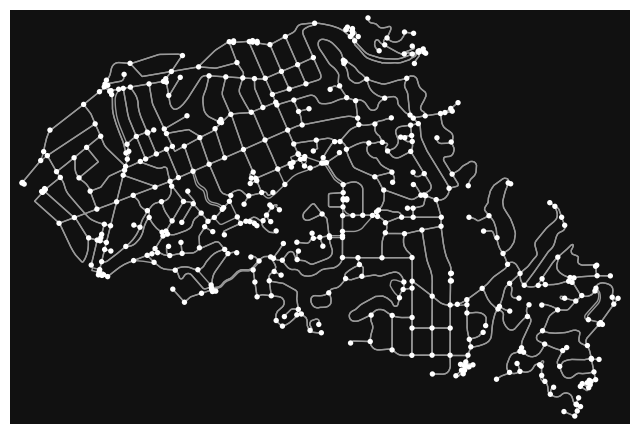

In [3]:
# Increase max query area size (e.g., to 100km * 100km)
# The default is 50km * 50km = 2,500,000,000
#new_max_size = 100000 * 100000  # units are meters
#ox.config(max_query_area_size=new_max_size)

# download/model a street network for some city then visualize it
G = ox.graph.graph_from_place("Piedmont, California, USA", network_type="bike")
fig, ax = ox.plot.plot_graph(G)

The histogram shows a strongly right-skewed distribution of street segment lengths, with most values concentrated between 0 and 25 meters. This indicates that the cycling network is made up of very short and highly segmented paths, which may reflect dense infrastructure, frequent intersections, or mapping granularity. By removing the top 5% of outliers, the analysis focuses on the core structure without distortion from unusually long segments.

In [4]:
# Get the edges
edges = ox.graph_to_gdfs(G, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
# Your data starts in a standard geographic CRS
gdf = gpd.GeoDataFrame(edges, crs="EPSG:4326")
# Re-project the data to the correct projected CRS for Piedmont, CA
#    UTM Zone 10N (EPSG:32610) is appropriate here.
gdf_proj = gdf.to_crs("EPSG:32610")
centroids = gdf_proj.geometry.centroid
coords = pd.DataFrame({'x': centroids.x, 'y': centroids.y})

# Handle list entries in 'highway' column by converting them to strings
gdf['highway'] = gdf['highway'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# One-Hot Encode the 'highway' column
highway_dummies = pd.get_dummies(gdf['highway'], prefix='highway')
# Combine coordinates and encoded columns into a single feature set
# We reset the index to prevent alignment issues
features = pd.concat([coords.reset_index(drop=True), highway_dummies.reset_index(drop=True)], axis=1)
# Scale the combined features so coordinates don't dominate
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# --- CLUSTERING ---
# Run clustering on the new scaled feature set
# NOTE: Parameters MUST be re-tuned now. 'eps' is no longer in meters.
db = DBSCAN(eps=1.5, min_samples=5).fit(features_scaled)
gdf['dbscan_combined_cluster'] = db.labels_
kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto').fit(features_scaled)
gdf['kmeans_combined_cluster'] = kmeans.labels_
# The new cluster labels are now in your GeoDataFrame, ready for visualization
print(gdf[['highway', 'kmeans_combined_cluster']].head())

                           highway  kmeans_combined_cluster
u        v        key                                      
53017091 53064327 0    residential                        1
         53075599 0    residential                        1
53018397 53018399 0    residential                        1
         53018411 0       tertiary                        3
         53097980 0       tertiary                        3


Index(['osmid', 'highway', 'name', 'oneway', 'reversed', 'length', 'geometry',
       'lanes', 'maxspeed', 'bridge', 'service', 'junction', 'access',
       'dbscan_combined_cluster', 'kmeans_combined_cluster'],
      dtype='object')


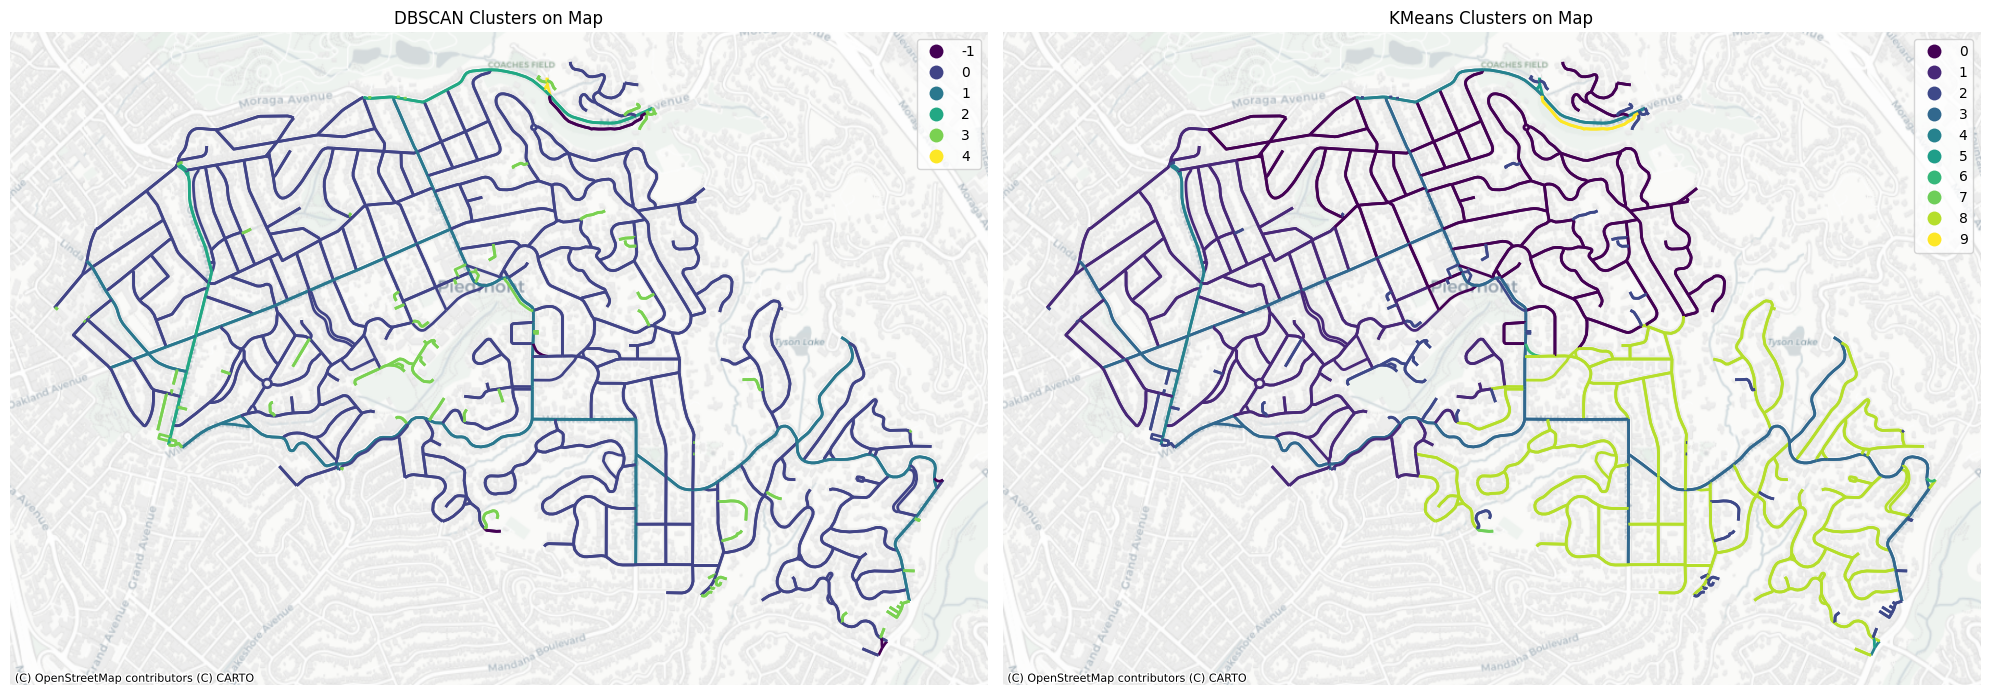

In [5]:
plot_clusters(gdf)

# Next Step
In the above attempt, the methods are not trying to find the areas via clustering using the highway parameter. We used both methods just to test them. Here are the results:  
Both methods are clustering the exact same input data, but they are producing very different outputs because their clustering logic is fundamentally different.

## Key Differences

| Feature             | DBSCAN                                                                 | KMeans                                                                 |
|---------------------|------------------------------------------------------------------------|------------------------------------------------------------------------|
| Input Data          | Acts on the (x, y) coordinates of the road centroids                   | Acts on the exact same (x, y) coordinates of the road centroids       |
| How it Works        | Density-based. Groups points that are closely packed together, marking points in low-density regions as noise. Finds clusters based on a search radius (eps) | Centroid-based. Partitions data into a specified number (k) of clusters, where each point belongs to the cluster with the nearest mean (centroid)                                       |
| Number of Clusters  | Determined automatically based on data density. In this case, it found 25 clusters  | Must be specified beforehand. n_clusters=10, so it was forced to create exactly 10 clusters |
| Cluster Shape       | Can find arbitrarily shaped clusters                                  | Tends to create roughly spherical, evenly-sized clusters              |


THe visualizations perfectly illustrate the difference between the two algorithms:

- **KMeans (Right Image):** This method partitioned your map into 10 large, distinct zones. Because k=10, it divided all the road segments among those 10 groups,
with each group centered around a calculated point. This is useful for tasks like creating 10 service districts or sales territories.

- **DBSCAN (Left Image):** This method acted like a truffle hunter, finding 25 smaller, more granular pockets of high road density.
It didn't try to assign every single road to a large zone. Instead, it identified tight, local groupings.
This is useful for identifying distinct neighborhoods or areas of dense development.

In short, while they both started with the same location data, KMeans answered "How can I split this map into 10 zones?" while DBSCAN answered
"Where are the dense clusters of roads on this map?"

This is not what we want. We want: both methods to cluster the highway column to id where these categories in the map.
We have to a form of one-hot-coding on `highway`

In [7]:
# Analyze KMeans clusters
print("KMeans Cluster Analysis:")
for cluster_label in gdf['kmeans_combined_cluster'].unique():
    cluster_gdf = gdf[gdf['kmeans_combined_cluster'] == cluster_label]
    print(f"\nCluster {cluster_label}:")
    print(cluster_gdf['highway'].value_counts().head()) # Show top highway types

# Analyze DBSCAN clusters
print("\nDBSCAN Cluster Analysis:")
for cluster_label in gdf['dbscan_combined_cluster'].unique():
    cluster_gdf = gdf[gdf['dbscan_combined_cluster'] == cluster_label]
    print(f"\nCluster {cluster_label}:")
    print(cluster_gdf['highway'].value_counts().head()) # Show top highway types

KMeans Cluster Analysis:

Cluster 1:
highway
residential    282
Name: count, dtype: int64

Cluster 3:
highway
tertiary    177
Name: count, dtype: int64

Cluster 8:
highway
residential    291
Name: count, dtype: int64

Cluster 0:
highway
residential    246
Name: count, dtype: int64

Cluster 4:
highway
secondary    60
Name: count, dtype: int64

Cluster 2:
highway
service    176
Name: count, dtype: int64

Cluster 5:
highway
unclassified    10
Name: count, dtype: int64

Cluster 9:
highway
path    2
Name: count, dtype: int64

Cluster 6:
highway
tertiary_link    2
Name: count, dtype: int64

Cluster 7:
highway
residential, service    2
Name: count, dtype: int64

DBSCAN Cluster Analysis:

Cluster 0:
highway
residential    819
Name: count, dtype: int64

Cluster 1:
highway
tertiary    177
Name: count, dtype: int64

Cluster -1:
highway
secondary               2
path                    2
tertiary_link           2
residential, service    2
unclassified            1
Name: count, dtype: int64

Cluste

# Task
Generate Python code to visualize the spatial distribution of clusters from KMeans and DBSCAN analysis on a map, where each cluster is colored based on the dominant highway type within that cluster.

## Determine dominant highway type

### Subtask:
For each cluster (in both KMeans and DBSCAN results), identify the most frequent highway type.


**Reasoning**:
Iterate through KMeans and DBSCAN clusters to find the dominant highway type for each and store them in dictionaries.



In [8]:
# Find dominant highway type for each KMeans cluster
kmeans_dominant_highway = {}
for cluster_label in gdf['kmeans_combined_cluster'].unique():
    cluster_gdf = gdf[gdf['kmeans_combined_cluster'] == cluster_label]
    # Use .mode()[0] to get the first mode in case of ties
    dominant_highway = cluster_gdf['highway'].mode()
    if not dominant_highway.empty:
        kmeans_dominant_highway[cluster_label] = dominant_highway[0]
    else:
        kmeans_dominant_highway[cluster_label] = None # Handle empty clusters


# Find dominant highway type for each DBSCAN cluster
dbscan_dominant_highway = {}
for cluster_label in gdf['dbscan_combined_cluster'].unique():
    cluster_gdf = gdf[gdf['dbscan_combined_cluster'] == cluster_label]
    dominant_highway = cluster_gdf['highway'].mode()
    if not dominant_highway.empty:
        dbscan_dominant_highway[cluster_label] = dominant_highway[0]
    else:
        dbscan_dominant_highway[cluster_label] = None # Handle empty clusters

print("KMeans Dominant Highway Types per Cluster:")
print(kmeans_dominant_highway)
print("\nDBSCAN Dominant Highway Types per Cluster:")
print(dbscan_dominant_highway)

KMeans Dominant Highway Types per Cluster:
{np.int32(1): 'residential', np.int32(3): 'tertiary', np.int32(8): 'residential', np.int32(0): 'residential', np.int32(4): 'secondary', np.int32(2): 'service', np.int32(5): 'unclassified', np.int32(9): 'path', np.int32(6): 'tertiary_link', np.int32(7): 'residential, service'}

DBSCAN Dominant Highway Types per Cluster:
{np.int64(0): 'residential', np.int64(1): 'tertiary', np.int64(-1): 'path', np.int64(2): 'secondary', np.int64(3): 'service', np.int64(4): 'unclassified'}


## Map cluster labels to dominant highway types

### Subtask:
Create a mapping from the numerical cluster labels to their corresponding dominant highway types.


**Reasoning**:
Map the dominant highway types to the cluster labels in the gdf DataFrame and display the results.



In [9]:
# Map KMeans cluster labels to dominant highway types
gdf['kmeans_dominant_highway_type'] = gdf['kmeans_combined_cluster'].map(kmeans_dominant_highway)

# Map DBSCAN cluster labels to dominant highway types
gdf['dbscan_dominant_highway_type'] = gdf['dbscan_combined_cluster'].map(dbscan_dominant_highway)

# Display the first few rows including the new columns
print(gdf[['highway', 'kmeans_combined_cluster', 'kmeans_dominant_highway_type', 'dbscan_combined_cluster', 'dbscan_dominant_highway_type']].head())

                           highway  kmeans_combined_cluster  \
u        v        key                                         
53017091 53064327 0    residential                        1   
         53075599 0    residential                        1   
53018397 53018399 0    residential                        1   
         53018411 0       tertiary                        3   
         53097980 0       tertiary                        3   

                      kmeans_dominant_highway_type  dbscan_combined_cluster  \
u        v        key                                                         
53017091 53064327 0                    residential                        0   
         53075599 0                    residential                        0   
53018397 53018399 0                    residential                        0   
         53018411 0                       tertiary                        1   
         53097980 0                       tertiary                        1   

    

## Modify plotting function

### Subtask:
Modify the `plot_clusters` function to use the new columns containing the dominant highway types for coloring the map.


**Reasoning**:
Modify the plot_clusters function to use the newly created columns for coloring the map.



In [10]:
def plot_clusters(gdf):

    # --- Create the Map Visualization ---
    # Create two subplots side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # --- Plot 1: DBSCAN Clusters colored by dominant highway type ---
    gdf.plot(
        column='dbscan_dominant_highway_type', # Color roads by dominant highway type
        categorical=True,       # Treat dominant highway types as distinct categories
        legend=True,            # Show the legend
        linewidth=2,            # Make lines thicker
        ax=ax1,                 # Draw on the first subplot
        cmap='tab10'            # Use a categorical colormap
    )
    ax1.set_title('DBSCAN Clusters by Dominant Highway Type')
    ax1.set_axis_off()
    # Add a basemap for context (requires re-projecting on the fly)
    ctx.add_basemap(ax1, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

    # --- Plot 2: KMeans Clusters colored by dominant highway type ---
    gdf.plot(
        column='kmeans_dominant_highway_type', # Color roads by dominant highway type
        categorical=True,
        legend=True,
        linewidth=2,
        ax=ax2,
        cmap='tab10' # Use a categorical colormap
    )
    ax2.set_title('KMeans Clusters by Dominant Highway Type')
    ax2.set_axis_off()
    # Add a basemap for context
    ctx.add_basemap(ax2, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

    plt.tight_layout()
    plt.show()

**Reasoning**:
Call the modified plot_clusters function to visualize the clusters colored by dominant highway type.



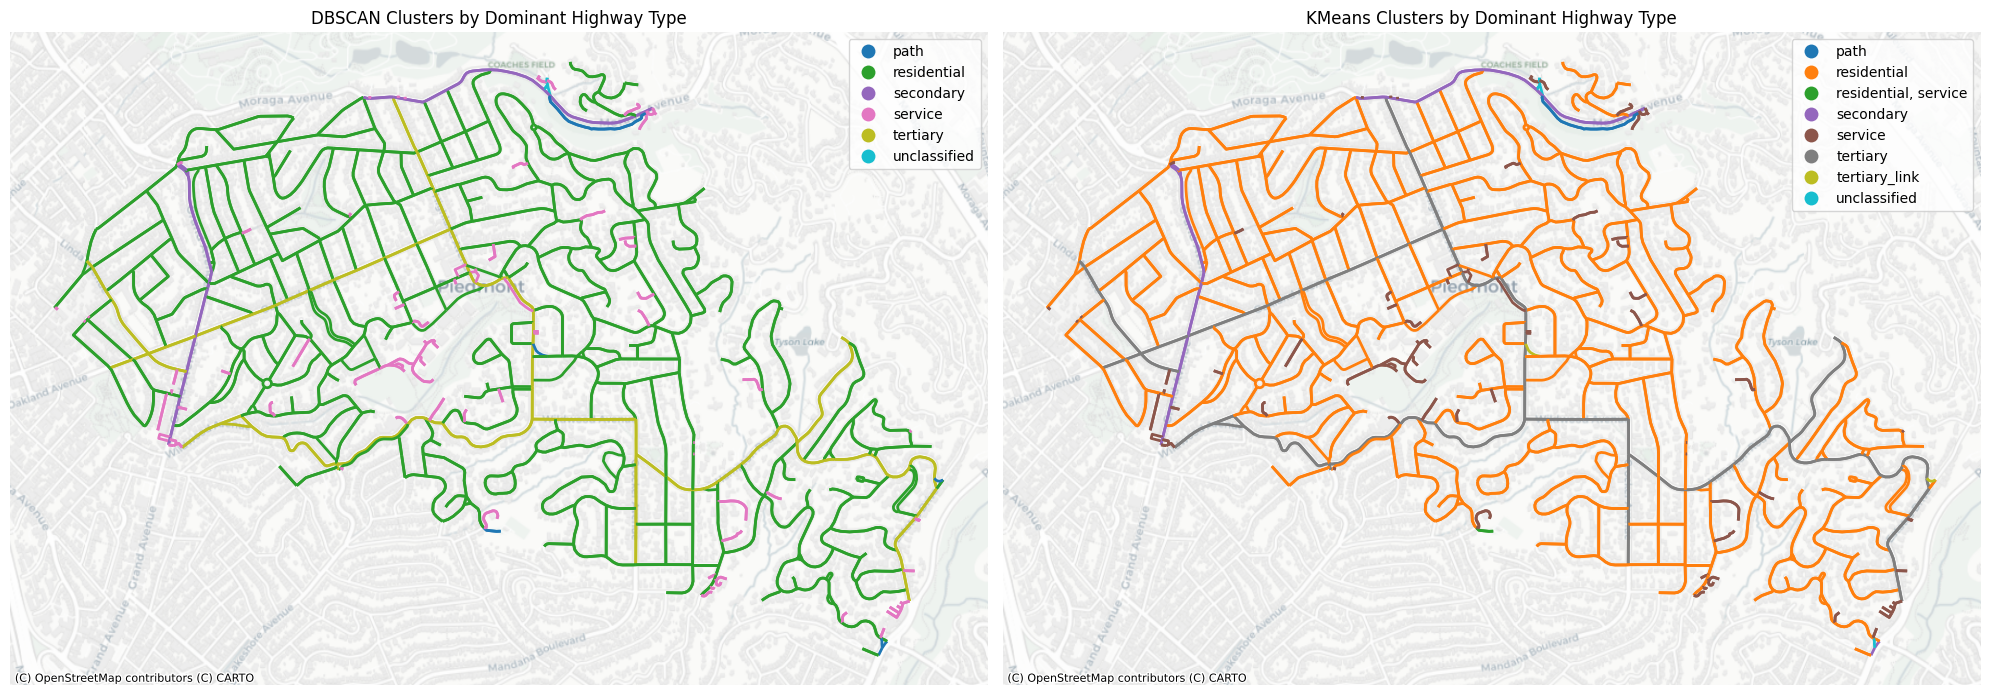

In [11]:
plot_clusters(gdf)

## Summary:

### Data Analysis Key Findings

*   For KMeans clusters, the dominant highway types were identified for each cluster label. For example, cluster 1 is dominated by 'residential' highways.
*   For DBSCAN clusters, the dominant highway types were also determined. Cluster 0 is dominated by 'residential' highways, while the noise cluster (-1) is dominated by 'path' highways.
*   Two new columns, `kmeans_dominant_highway_type` and `dbscan_dominant_highway_type`, were added to the GeoDataFrame, mapping the cluster labels to their respective dominant highway types.
*   The plotting function was successfully modified to color the clusters on the map based on these newly added dominant highway type columns, using a categorical colormap and displaying a legend.

### Insights or Next Steps

*   The visualizations allow for a spatial understanding of how different highway types are clustered by both algorithms.
*   Comparing the KMeans and DBSCAN maps colored by dominant highway type can provide insights into how each algorithm groups areas with similar road characteristics.
